# Load data

In [1]:
import os
import gc
import pandas as pd

import pickle
from collections import Counter
from tqdm import tqdm
import numpy as np
import random

import json
import ast
from sklearn.metrics import *

import matplotlib.pyplot as plt
import seaborn as sns

# Compare all situations vs. 17K situations in an embedding space

In [20]:
df1 = pd.read_csv(f"{os.getcwd()}/data/data_active_situationExt.tsv", sep="\t")
print(len(df1))
# df1 = df1[['subID', 'title', 'selftext']]
# df1.drop_duplicates(inplace=True)
# all_texts = [elem1+' '+elem2 for elem1,elem2 in zip(df1.title.tolist(), df1.selftext.tolist()) if elem1==elem1 and elem2==elem2]
# del df1
# gc.collect()

891165


In [4]:
import openai
from openai import OpenAI
from tenacity import (
    retry,
    stop_after_attempt,
    wait_random_exponential,
)

# Load your API key from an environment variable or secret management service
openai.api_key = os.getenv("OPENAI_API_KEY")
client = OpenAI()

@retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(6))
def completion_with_backoff(**kwargs):
    return client.chat.completions.create(**kwargs)
import tiktoken
encoding = tiktoken.encoding_for_model("gpt-4o")

def slice_text_list(text_list, thr=8000):
    cnt = 0
    final_slice, sub_slice = [], []
    for text in text_list:
        encoded = encoding.encode(text)
        if cnt + len(encoded) < thr:
            sub_slice.append(text)
            cnt += len(encoded)
        else:
            final_slice.append(sub_slice)
            sub_slice = [text]
            cnt = len(encoded)
    final_slice.append(sub_slice)
    return final_slice

def normalize_l2(x):
    x = np.array(x)
    if x.ndim == 1:
        norm = np.linalg.norm(x)
        if norm == 0:
            return x
        return x / norm
    else:
        norm = np.linalg.norm(x, 2, axis=1, keepdims=True)
        return np.where(norm == 0, x, x / norm)

def process_dimensions(input_text):
    text_list = input_text.split('\n')
    return_list = []
    for text in text_list:
        if text.strip() == '':
            continue
        text = text.replace('[Answer]','').replace('**','').replace('- ','').strip()
        if text[0].isdigit():
            text = text[1:]
        if text[0]=='.':
            text = text[1:]
        return_list.append(text.strip())
    return '\n'.join(return_list)

def get_embeddings(all_texts, emb_model="text-embedding-3-large"):
    all_texts_sliced = slice_text_list(all_texts)
    all_embeddings = []
    for texts in tqdm(all_texts_sliced):
        results = []
        prompt_texts = [text.replace('\n',' ') for text in texts]

        response = client.embeddings.create(input=prompt_texts,model=emb_model)
        full_emb = [item.embedding for item in response.data]
        all_embeddings += [normalize_l2(emb[:256]) for emb in full_emb]
    return all_embeddings

In [5]:
situation_reduced_emb = get_embeddings(all_texts, emb_model="text-embedding-3-small")
# situation_reduced_emb = [normalize_l2(emb[:256]) for emb in all_situation_embeddings]

100%|█████████████████████████████████████████████████████████████████████| 12120/12120 [1:51:59<00:00,  1.80it/s]


In [11]:
df2 = pd.read_csv(f"{os.getcwd()}/data/data_active.tsv", sep="\t")
df2 = df2[['subID', 'title', 'selftext']]
df2.drop_duplicates(inplace=True)
all_text2 = [elem1+' '+elem2 for elem1,elem2 in zip(df2.title.tolist(), df2.selftext.tolist()) if elem1==elem1 and elem2==elem2]
del df2
gc.collect()

821

In [13]:
small_situation_emb = get_embeddings(all_text2, emb_model="text-embedding-3-small")
# situation_reduced_emb = [normalize_l2(emb[:256]) for emb in all_situation_embeddings]

100%|█████████████████████████████████████████████████████████████████████████| 1135/1135 [09:44<00:00,  1.94it/s]


In [6]:
with open(f'{os.getcwd()}/embedding/Situation_text-embedding-3-large.pkl', 'rb') as f:
    _dict = pickle.load(f)
    small_situation_emb = _dict['embedding_reduced']

In [ ]:
all_embeddings = np.vstack([np.array(situation_reduced_emb), np.array(small_situation_emb)])

In [14]:
all_embeddings2 = np.vstack([np.array(situation_reduced_emb), np.array(small_situation_emb)])

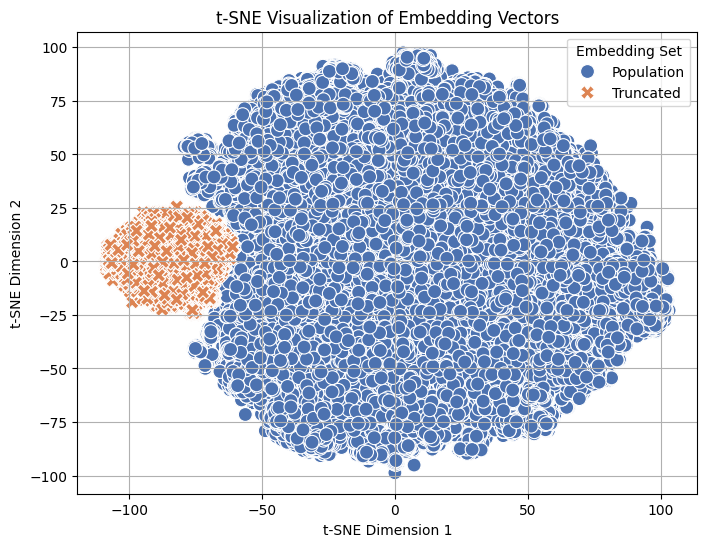

In [8]:
from sklearn.manifold import TSNE
# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca')
reduced = tsne.fit_transform(all_embeddings)

# Create labels
labels = ['Population'] * len(situation_reduced_emb) + ['Truncated'] * len(small_situation_emb)

# Build DataFrame
df = pd.DataFrame({
    'Dim1': reduced[:, 0],
    'Dim2': reduced[:, 1],
    'Label': labels
})

# Plot with seaborn
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df, x='Dim1', y='Dim2', hue='Label', style='Label',
    markers={'Population': 'o', 'Truncated': 'X'}, s=100, palette='deep'
)
plt.title('t-SNE Visualization of Embedding Vectors')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Embedding Set')
plt.grid(True)
plt.show()

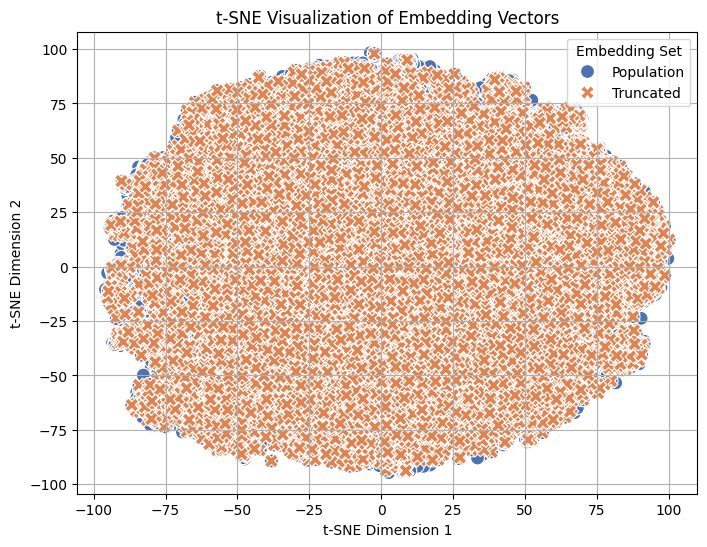

<Axes: title={'center': 't-SNE Visualization of Embedding Vectors'}, xlabel='t-SNE Dimension 1', ylabel='t-SNE Dimension 2'>

In [18]:
from sklearn.manifold import TSNE
# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca')
reduced = tsne.fit_transform(all_embeddings2)

# Create labels
labels = ['Population'] * len(situation_reduced_emb) + ['Truncated'] * len(small_situation_emb)

# Build DataFrame
df = pd.DataFrame({
    'Dim1': reduced[:, 0],
    'Dim2': reduced[:, 1],
    'Label': labels
})

# Plot with seaborn
plt.figure(figsize=(8, 6))
g1 = sns.scatterplot(
    data=df, x='Dim1', y='Dim2', hue='Label', style='Label',
    markers={'Population': 'o', 'Truncated': 'X'}, s=100, palette='deep'
)
plt.title('t-SNE Visualization of Embedding Vectors')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Embedding Set')
plt.grid(True)
plt.show()
g1

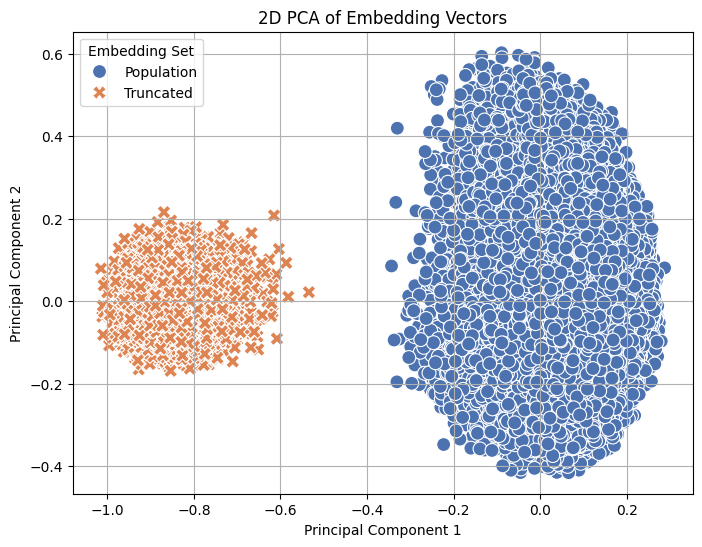

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
reduced = pca.fit_transform(all_embeddings)

# Create labels
labels = ['Population'] * len(situation_reduced_emb) + ['Truncated'] * len(small_situation_emb)

# Build DataFrame for Seaborn
df = pd.DataFrame({
    'PC1': reduced[:, 0],
    'PC2': reduced[:, 1],
    'Label': labels
})

# Plot using seaborn
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='PC1', y='PC2', hue='Label', style='Label',
                markers={'Population': 'o', 'Truncated': 'X'}, s=100, palette='deep')
plt.title('2D PCA of Embedding Vectors')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Embedding Set')
plt.grid(True)
plt.show()

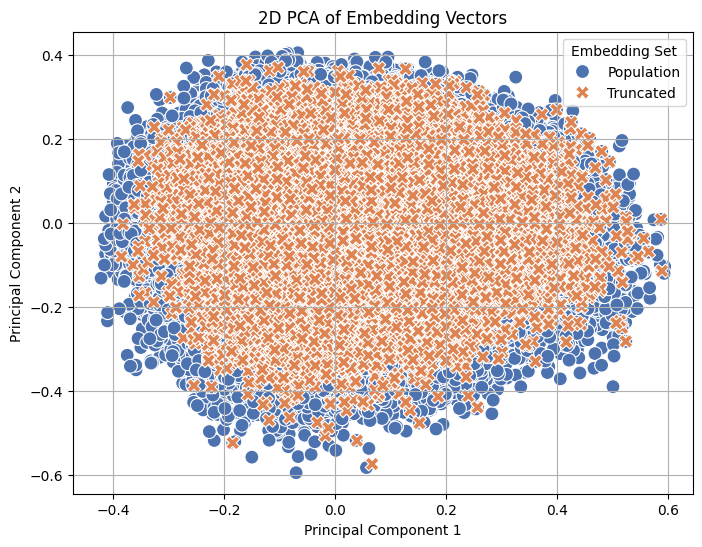

<Axes: title={'center': '2D PCA of Embedding Vectors'}, xlabel='Principal Component 1', ylabel='Principal Component 2'>

In [17]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
reduced = pca.fit_transform(all_embeddings2)

# Create labels
labels = ['Population'] * len(situation_reduced_emb) + ['Truncated'] * len(small_situation_emb)

# Build DataFrame for Seaborn
df = pd.DataFrame({
    'PC1': reduced[:, 0],
    'PC2': reduced[:, 1],
    'Label': labels
})

# Plot using seaborn
plt.figure(figsize=(8, 6))
g = sns.scatterplot(data=df, x='PC1', y='PC2', hue='Label', style='Label',
                markers={'Population': 'o', 'Truncated': 'X'}, s=100, palette='deep')
plt.title('2D PCA of Embedding Vectors')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Embedding Set')
plt.grid(True)
plt.show()
g

In [19]:
g.figure.savefig(f'{os.getcwd()}/diagram/pca_population_vs_truncated.png', bbox_inches='tight')

# Author attributes

In [18]:
with open(f"{os.getcwd()}//data/author_to_controversialIndex_byRedditor.pkl", "rb") as f:
    author_to_testHardIdx = pickle.load(f)

"""
author_to_controversialRatio:
- closer to 0 -> tend to participate on non-controversial situations
- closer to 1 -> tend to participate on more controversial situations
"""
author_to_controversialRatio = {} # 
for _author in author_to_testHardIdx:
    author_to_controversialRatio[_author] = sum(author_to_testHardIdx[_author])/len(author_to_testHardIdx[_author])

In [21]:
"""
author_to_judgmentPatterns:
- closer to 0 -> tend to say 'not acceptable' more
- closer to 1 -> tend to say 'acceptable' more
- closer to 0.5 -> balanced judgment
"""

with open(f"{os.getcwd()}//data/subID_to_votes.pkl", "rb") as f:
    subID_to_votes = pickle.load(f)
with open(f"{os.getcwd()}//data/author_to_subID_to_inst.pkl", "rb") as f:
    author_to_subID_to_inst = pickle.load(f)
    
author_to_judgmentPatterns, author_to_numInst, author_to_numInst_log = {}, {}, {}
for _author in author_to_subID_to_inst:
    _patterns = []
    for _subID in author_to_subID_to_inst[_author]:
        _patterns.append(author_to_subID_to_inst[_author][_subID]['judgment'])
    author_to_judgmentPatterns[_author] = 1-abs(0.5-sum(_patterns)/len(_patterns))*2
    author_to_numInst[_author] = len(_patterns)
    author_to_numInst_log[_author] = np.log(len(_patterns))

In [22]:
"""
author_to_majorityRatio:
- closer to 0 -> tend to align with majority 
- closer to 1 -> tend to be outlier
"""

author_to_majorityRatio = {}
for _author in author_to_subID_to_inst:
    _tendencies = []
    for _subID in author_to_subID_to_inst[_author]:
        _val = sum(subID_to_votes[_subID])/len(subID_to_votes[_subID])
        _majority = round(_val)
        _judgment = author_to_subID_to_inst[_author][_subID]['judgment']
        
        if _majority != _judgment and (_val < 0.3 or _val > 0.7):
            _tendencies.append(1)
        else:
            _tendencies.append(0)

    author_to_majorityRatio[_author] = sum(_tendencies)/len(_tendencies)

In [23]:
author_to_numInst_judgmentPatterns = {}
for _author in author_to_subID_to_inst:
    author_to_numInst_judgmentPatterns[_author] = author_to_numInst_log[_author] * author_to_judgmentPatterns[_author]

# Visualize based on author attributes
1. by overall F1
2. by minority-class F1

In [70]:
import seaborn as sns

In [168]:
finetune_dir = os.getcwd()+'/outputs/'
model_ckpts = ['distilbert-base-uncased', 'roberta-base', 'deberta-v3-large', 
                'bart-base', 'bart-base_seq2seq', 'flan-t5-base', 'flan-t5-base_seq2seq']
num_folds = 5

In [21]:
def reconstruct_labels_preds(precision, recall, num_support, num_inst, _class):
    if precision == 0:
        _label = [_class]*num_support + [1-_class]*(num_inst-num_support)
        _pred = [1-_class]*num_support + [_class]*(num_inst-num_support)
        return _label, _pred
    tp = round(num_support * recall)
    fn = num_support - tp
    fp = round(tp / precision) - tp
    tn = num_inst - tp - fn - fp
    _label = [_class]*num_support + [1-_class]*(num_inst-num_support)
    _preds = [_class]*tp + [1-_class]*fn + [_class]*fp + [1-_class]*tn
    return _label, _preds

In [170]:
def viz_f1(ckpt, attribute, attr_dict, mode='overall'):
    _dict = {'author':[], 'fold':[], 'f1':[], f'{attribute}':[]}
    for i in range(num_folds):
        if os.path.exists(f'{finetune_dir}/{_ckpt}_author_results.pkl'):
            with open(f'{finetune_dir}/{_ckpt}_author_results.pkl', 'rb') as f:
                _author_results = pickle.load(f)
            for _author in _author_results:
                _dict['author'].append(_author)
                _dict['fold'].append(i)
                _dict[f'{attribute}'].append(attr_dict[_author])
                if mode == 'overall':
                    _dict['f1'].append(_author_results[_author][i]['macro avg']['f1-score'])
                elif mode == 'minority':
                    class0sup = _author_results[_author][i]['Not Acceptable']['support']
                    class1sup = _author_results[_author][i]['Acceptable']['support']
                    if class0sup>class1sup:
                        _dict['f1'].append(_author_results[_author][i]['Acceptable']['f1-score'])
                    else:
                        _dict['f1'].append(_author_results[_author][i]['Not Acceptable']['f1-score'])
                else:
                    raise NotImplementedError
    df_viz = pd.DataFrame(data=_dict)
    # sns.lineplot(data=df_viz, x=f'{attribute}', y="f1", hue="fold", err_style="bars", errorbar=("se", 2),)
    sns.scatterplot(data=df_viz, x=f'{attribute}', y="f1", )
    # sns.lineplot(data=df_viz, x=f'{attribute}', y="f1", hue="fold",)

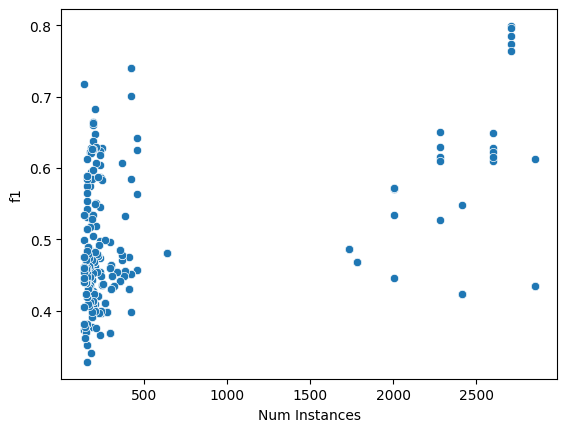

In [173]:
viz_f1('roberta-base', 'Num Instances', author_to_numInst)

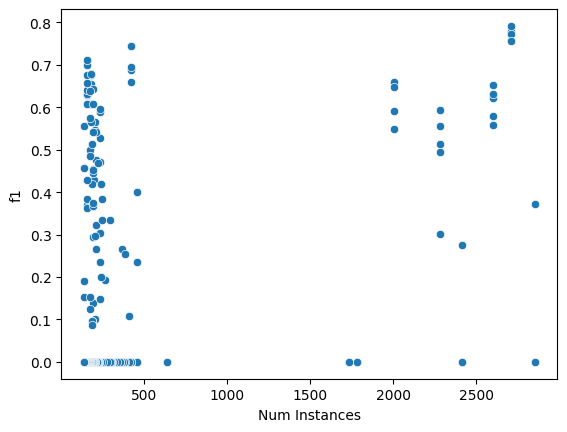

In [174]:
viz_f1('roberta-base', 'Num Instances', author_to_numInst, mode='minority')

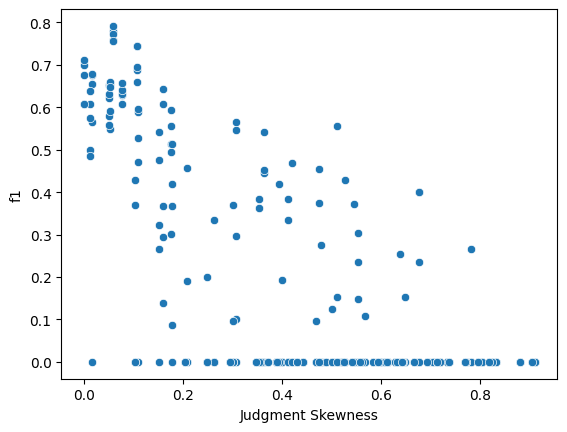

In [175]:
viz_f1('roberta-base', 'Judgment Skewness', author_to_judgmentPatterns, mode='minority')

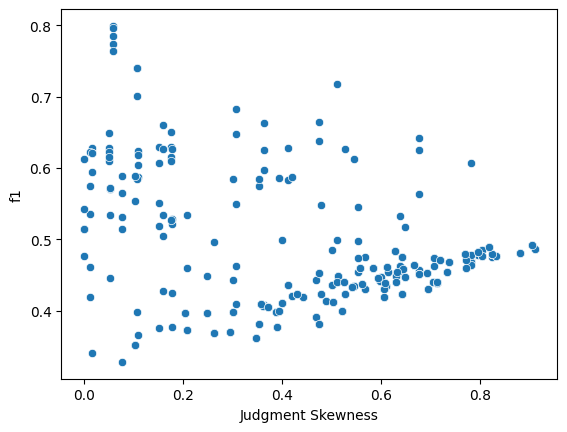

In [176]:
viz_f1('roberta-base', 'Judgment Skewness', author_to_judgmentPatterns)

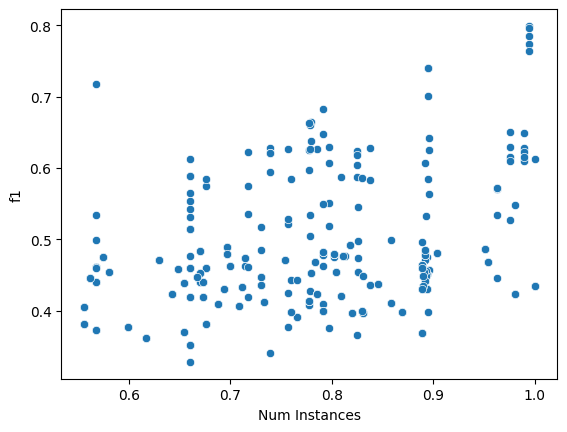

In [171]:
viz_f1('roberta-base', 'Num Instances', author_to_numInst_flat)

# Fine-tuned models

In [9]:
output_dir = os.getcwd()+'/outputs/'
model_ckpts = ['distilbert-base-uncased', 'roberta-base', 'deberta-v3-large', 
                'bart-base', 'bart-base_seq2seq', 'flan-t5-base', 'flan-t5-base_seq2seq']
num_folds = 5

In [44]:
def reconstruct_labels_preds(precision, recall, num_support, num_inst, _class):
    if precision == 0:
        _label = [_class]*num_support + [1-_class]*(num_inst-num_support)
        _pred = [1-_class]*num_support + [_class]*(num_inst-num_support)
        return _label, _pred
    tp = round(num_support * recall)
    fn = num_support - tp
    fp = round(tp / precision) - tp
    tn = num_inst - tp - fn - fp
    _label = [_class]*num_support + [1-_class]*(num_inst-num_support)
    _preds = [_class]*tp + [1-_class]*fn + [_class]*fp + [1-_class]*tn
    return _label, _preds

In [22]:
_class_to_key ={0:'Not Acceptable', 1:'Acceptable'}
for _ckpt in model_ckpts:
    all_label, all_preds = [], []
    for i in range(num_folds):
        if os.path.exists(f'{output_dir}/{_ckpt}_author_results.pkl'):
            with open(f'{output_dir}/{_ckpt}_author_results.pkl', 'rb') as f:
                _author_results = pickle.load(f)
            for _author in _author_results:
                _class = 0 if _author_results[_author][i]['Acceptable']['f1-score'] == 0.0 else 1
                _dict = _author_results[_author][i][_class_to_key[_class]]
                _label, _preds = reconstruct_labels_preds(_dict['precision'], _dict['recall'], int(_dict['support']), int(_author_results[_author][i]['macro avg']['support']), _class)
                all_label += _label
                all_preds += _preds
    print(_ckpt)
    print(classification_report(all_label, all_preds, target_names=['Not Acceptable','Acceptable'], digits=4))

distilbert-base-uncased
                precision    recall  f1-score   support

Not Acceptable     0.5815    0.3747    0.4557     16270
    Acceptable     0.7835    0.8935    0.8349     41210

      accuracy                         0.7467     57480
     macro avg     0.6825    0.6341    0.6453     57480
  weighted avg     0.7263    0.7467    0.7276     57480

roberta-base
                precision    recall  f1-score   support

Not Acceptable     0.6105    0.3717    0.4621     16270
    Acceptable     0.7851    0.9064    0.8414     41210

      accuracy                         0.7550     57480
     macro avg     0.6978    0.6390    0.6517     57480
  weighted avg     0.7357    0.7550    0.7340     57480

deberta-v3-large
                precision    recall  f1-score   support

Not Acceptable     0.5013    0.2496    0.3333     16270
    Acceptable     0.7527    0.9020    0.8206     41210

      accuracy                         0.7173     57480
     macro avg     0.6270    0.5758    0.5

## Regression

In [162]:
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

import matplotlib.pyplot as plt
import seaborn as sns

In [164]:
_ckpt = 'roberta-base'
finetune_dir = os.getcwd()+'/outputs/'
with open(f'{finetune_dir}/{_ckpt}_author_results.pkl', 'rb') as f:
    _author_results = pickle.load(f)

In [166]:
for i in range(5):
    X, y = [], []
    for _author in _author_results:
        
        X.append([np.log(author_to_numInst[_author]), author_to_judgmentPatterns[_author], author_to_majorityRatio[_author], author_to_controversialRatio[_author]])
        y.append(_author_results[_author][i]['macro avg']['f1-score'])
    reg = LinearRegression().fit(X, y)
    # reg = linear_model.Lasso().fit(X, y)

    # pr = PolynomialFeatures(degree = 4)
    # X_poly = pr.fit_transform(X)
    # reg2 = LinearRegression().fit(X_poly, y)

    print(f"===[Fold {i}]===")
    print(reg.score(X, y))
    print(reg.coef_)
    print(reg.intercept_)
    # print(reg2.score(X_poly, y))
    # print(reg2.coef_)
    # print(reg2.intercept_)
    
    print()

===[Fold 0]===
0.32085476728972784
[ 0.0472519  -0.07614598 -0.12122737 -0.0794376 ]
0.24964976336209482

===[Fold 1]===
0.22725145164420468
[ 0.04134979 -0.10358181 -0.50361341  0.01819192]
0.31094713716962186

===[Fold 2]===
0.21229652870623583
[ 0.03719109 -0.07660215 -0.60194247  0.19363429]
0.30248299507985554

===[Fold 3]===
0.24691539805363538
[ 0.03940448 -0.10452295 -0.57692984 -0.12391208]
0.32731938076068495

===[Fold 4]===
0.2235736522570897
[ 0.03621385 -0.10697475 -0.51139569  0.08485028]
0.3338952015942574



In [105]:
X, y = [], []
for _author in _author_results:
    X.append([np.log(author_to_numInst[_author]), author_to_judgmentPatterns[_author], author_to_majorityRatio[_author], author_to_HardRatio[_author]])
    y.append(_author_results[_author][0]['macro avg']['f1-score'])

X_grid = np.arange(min(X), max(X), 0.1)
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(X, y, color = 'lightcoral')
plt.plot(X, lr_2.predict(X_poly), color = 'firebrick')
plt.title('Real data (Polynomial Regression)')
plt.xlabel('Position Level')
plt.ylabel('Salary')
plt.legend(['X/y_pred_poly', 'X/y'], title = 'Salary/Level', loc='best', facecolor='white')
plt.box(False)
plt.show()

np.float64(0.03660951131769479)

In [111]:
X_poly

array([[1.00000000e+00, 7.95612635e+00, 7.72870662e-01, ...,
        2.12721427e-04, 3.70274005e-04, 6.44518237e-04],
       [1.00000000e+00, 7.90544165e+00, 5.29498525e-01, ...,
        9.38318932e-07, 5.31505426e-06, 3.01068228e-05],
       [1.00000000e+00, 7.86441990e+00, 4.74452555e-01, ...,
        3.11897017e-04, 7.43598207e-04, 1.77282328e-03],
       ...,
       [1.00000000e+00, 4.93447393e+00, 7.62589928e-01, ...,
        1.18912223e-05, 3.12776886e-05, 8.22702475e-05],
       [1.00000000e+00, 4.91998093e+00, 6.86131387e-01, ...,
        8.73889134e-06, 1.58271590e-05, 2.86648446e-05],
       [1.00000000e+00, 4.92725369e+00, 7.97101449e-01, ...,
        3.40342168e-05, 8.67621241e-05, 2.21179357e-04]], shape=(100, 70))

# LLM results

In [3]:
output_dir = os.getcwd()+'/gpt_inference/deepseek-chat/'
strategies = ['Situation', 'Schwartz', 'Value', 'AbstValue']

# strategies = [ 'Schwartz',]
n_trials = 2

In [22]:
for _strategy in strategies:
    trial_golds, trial_preds = {i:[] for i in range(n_trials)}, {i:[] for i in range(n_trials)}
    for _filename in os.listdir(output_dir):
        if _filename.endswith('.tsv') and f"_{_strategy}withSelftext" in _filename:
            df_ans = pd.read_csv(output_dir+_filename, sep='\t')
            for i in range(n_trials):
                if f"trial{i}" in _filename:
                    # print(_filename)
                    trial_golds[i] += df_ans['gold'].tolist()
                    trial_preds[i] += df_ans['pred'].tolist()
                    # print(classification_report(df_ans['gold'].tolist(), df_ans['pred'].tolist(), target_names=['Not Acceptable','Acceptable'], digits=4))
    print(f"\n===={_strategy}====")
    all_golds, all_preds = [], []
    for i in range(n_trials):
        print(f"[Trial {i}]")
        print(classification_report(trial_golds[i], trial_preds[i], target_names=['Not Acceptable','Acceptable'], digits=4))
        all_golds += trial_golds[i]
        all_preds += trial_preds[i]
    print("[[Overall]]")
    print(classification_report(all_golds, all_preds, target_names=['Not Acceptable','Acceptable'], digits=4))
    
    


====Situation====
[Trial 0]
                precision    recall  f1-score   support

Not Acceptable     0.6127    0.6927    0.6502      3254
    Acceptable     0.8721    0.8271    0.8490      8242

      accuracy                         0.7891     11496
     macro avg     0.7424    0.7599    0.7496     11496
  weighted avg     0.7986    0.7891    0.7927     11496

[Trial 1]
                precision    recall  f1-score   support

Not Acceptable     0.6132    0.6899    0.6493      3254
    Acceptable     0.8712    0.8282    0.8492      8242

      accuracy                         0.7891     11496
     macro avg     0.7422    0.7591    0.7492     11496
  weighted avg     0.7982    0.7891    0.7926     11496

[[Overall]]
                precision    recall  f1-score   support

Not Acceptable     0.6129    0.6913    0.6498      6508
    Acceptable     0.8716    0.8277    0.8491     16484

      accuracy                         0.7891     22992
     macro avg     0.7423    0.7595    0.7494

In [119]:
trial_golds, trial_preds = {i:[] for i in range(n_trials)}, {i:[] for i in range(n_trials)}
for _filename in os.listdir(output_dir):
    if _filename.endswith('.tsv') and f"Comment_AbstValue" in _filename:
        df_ans = pd.read_csv(output_dir+_filename, sep='\t')
        for i in range(n_trials):
            if f"trial{i}" in _filename:
                # print(_filename)
                trial_golds[i] += df_ans['gold'].tolist()
                trial_preds[i] += df_ans['pred'].tolist()
                # print(classification_report(df_ans['gold'].tolist(), df_ans['pred'].tolist(), target_names=['Not Acceptable','Acceptable'], digits=4))
# print(f"\n===={_strategy}====")
all_golds, all_preds = [], []

for i in range(n_trials):
    print(f"[Trial {i}]")
    print(classification_report(trial_golds[i], trial_preds[i], target_names=['Not Acceptable','Acceptable'], digits=4))
    all_golds += trial_golds[i]
    all_preds += trial_preds[i]
print("[[Overall]]")
print(classification_report(all_golds, all_preds, target_names=['Not Acceptable','Acceptable'], digits=4))

[Trial 0]
                precision    recall  f1-score   support

Not Acceptable     0.5884    0.6882    0.6344      4670
    Acceptable     0.8520    0.7885    0.8190     10629

      accuracy                         0.7579     15299
     macro avg     0.7202    0.7384    0.7267     15299
  weighted avg     0.7715    0.7579    0.7627     15299

[Trial 1]
                precision    recall  f1-score   support

Not Acceptable     0.5870    0.6948    0.6364      3254
    Acceptable     0.8701    0.8070    0.8373      8242

      accuracy                         0.7752     11496
     macro avg     0.7285    0.7509    0.7369     11496
  weighted avg     0.7900    0.7752    0.7805     11496

[[Overall]]
                precision    recall  f1-score   support

Not Acceptable     0.5878    0.6909    0.6352      7924
    Acceptable     0.8599    0.7966    0.8270     18871

      accuracy                         0.7653     26795
     macro avg     0.7239    0.7438    0.7311     26795
  weight

In [47]:
# trial_golds, trial_preds = {i:[] for i in range(n_trials)}, {i:[] for i in range(n_trials)}
# for _filename in os.listdir(output_dir):
#     if _filename.endswith('.tsv') and f"Comment_AbstValue" in _filename:
df_ans = pd.read_csv(f'{os.getcwd()}/vllm_inference/inferJudgment_5shots_SituationwithSelftext_Comment_trial0.tsv', sep='\t')
#         for i in range(n_trials):
#             if f"trial{i}" in _filename:
#                 # print(_filename)
#                 trial_golds[i] += df_ans['gold'].tolist()
#                 trial_preds[i] += df_ans['pred'].tolist()
#                 # print(classification_report(df_ans['gold'].tolist(), df_ans['pred'].tolist(), target_names=['Not Acceptable','Acceptable'], digits=4))
# # print(f"\n===={_strategy}====")
# all_golds, all_preds = [], []

# for i in range(n_trials):
#     print(f"[Trial {i}]")
#     print(classification_report(trial_golds[i], trial_preds[i], target_names=['Not Acceptable','Acceptable'], digits=4))
#     all_golds += trial_golds[i]
#     all_preds += trial_preds[i]
# print("[[Overall]]")
print(classification_report(df_ans['gold'].tolist(), df_ans['pred'].tolist(), target_names=['Not Acceptable','Acceptable'], digits=4))

                precision    recall  f1-score   support

Not Acceptable     0.2309    0.4195    0.2979      3254
    Acceptable     0.6618    0.4484    0.5346      8242

      accuracy                         0.4402     11496
     macro avg     0.4463    0.4340    0.4162     11496
  weighted avg     0.5398    0.4402    0.4676     11496



# Batched LLM Results

In [4]:
import json

In [5]:
output_dir = os.getcwd()+'/gpt_inference/gpt-4.1/'
batchfile_dir = os.getcwd()+'/data/gpt-batchfiles/'
strategies = ['Situation', 'Schwartz', 'Value', 'AbstValue', 'Comm-Value']
inputs =['Comment', 'AbstValue', 'Value', 'Schwartz']
n_trials = 2

In [6]:
def convert_pred_to_digit(labels, preds):
    pred_digits = []
    for _label, _pred in zip(labels, preds):
        if _pred.strip().isdigit():
            pred_digits.append(int(_pred.strip()))
        else:
            if '1' in _pred and '0' not in _pred:
                pred_digits.append(1)
            elif '0' in _pred and '1' not in _pred:
                pred_digits.append(0)
            elif 'acceptable' in _pred.lower() and 'unacceptable' not in _pred.lower():
                pred_digits.append(1)
            elif 'unacceptable' in _pred.lower() and 'Acceptable' not in _pred:
                pred_digits.append(0)
            else:
                pred_digits.append(1-_label)
            
    return pred_digits

In [7]:
def print_overall_results(_strategy, _input):
    trial_golds, trial_preds = {i:[] for i in range(n_trials)}, {i:[] for i in range(n_trials)}
    for _filename in os.listdir(output_dir):
        if f"_{_strategy}withSelftext" in _filename and f"Selftext_{_input}.jsonl" in _filename:
            df = pd.read_json(output_dir+_filename, lines=True)
            df['trial'] = df['custom_id'].apply(lambda x:int(x.split('_')[-1]))
            with open(batchfile_dir+_filename.replace(".jsonl", "__gold.pkl"), "rb") as f:
                id_to_gold = pickle.load(f)
            df_list = []
            for i in range(n_trials):
                minidf = df[df['trial']==i]
                _golds = minidf['custom_id'].apply(lambda x:id_to_gold[x]).tolist()
                _preds = minidf['response'].apply(lambda x:x['body']['choices'][0]['message']['content'])
                _preds = convert_pred_to_digit(_golds, _preds)

                trial_golds[i] += _golds
                trial_preds[i] += _preds
    print(f"[Strategy] {_strategy}, [Input] {_input}")
    all_golds, all_preds = [], []
    for i in range(n_trials):
        print(f"[Trial {i}]")
        print(classification_report(trial_golds[i], trial_preds[i], target_names=['Not Acceptable','Acceptable'], digits=4))
        all_golds += trial_golds[i]
        all_preds += trial_preds[i]
    print("[[Overall]]")
    print(classification_report(all_golds, all_preds, target_names=['Not Acceptable','Acceptable'], digits=4))

In [59]:
print_overall_results("Situation", 'Comment')

[Strategy] Situation, [Input] Comment
[Trial 0]
                precision    recall  f1-score   support

Not Acceptable     0.8169    0.5867    0.6829      3254
    Acceptable     0.8531    0.9481    0.8981      8242

      accuracy                         0.8458     11496
     macro avg     0.8350    0.7674    0.7905     11496
  weighted avg     0.8429    0.8458    0.8372     11496

[Trial 1]
                precision    recall  f1-score   support

Not Acceptable     0.8140    0.5808    0.6779      3254
    Acceptable     0.8513    0.9476    0.8969      8242

      accuracy                         0.8438     11496
     macro avg     0.8326    0.7642    0.7874     11496
  weighted avg     0.8407    0.8438    0.8349     11496

[[Overall]]
                precision    recall  f1-score   support

Not Acceptable     0.8154    0.5837    0.6804      6508
    Acceptable     0.8522    0.9478    0.8975     16484

      accuracy                         0.8448     22992
     macro avg     0.8338 

In [62]:
print_overall_results("Situation", 'AbstValue')

[Strategy] Situation, [Input] AbstValue
[Trial 0]
                precision    recall  f1-score   support

Not Acceptable     0.7674    0.5080    0.6113      3254
    Acceptable     0.8286    0.9392    0.8805      8242

      accuracy                         0.8172     11496
     macro avg     0.7980    0.7236    0.7459     11496
  weighted avg     0.8113    0.8172    0.8043     11496

[Trial 1]
                precision    recall  f1-score   support

Not Acceptable     0.7670    0.5138    0.6154      3254
    Acceptable     0.8302    0.9384    0.8810      8242

      accuracy                         0.8182     11496
     macro avg     0.7986    0.7261    0.7482     11496
  weighted avg     0.8123    0.8182    0.8058     11496

[[Overall]]
                precision    recall  f1-score   support

Not Acceptable     0.7672    0.5109    0.6134      6508
    Acceptable     0.8294    0.9388    0.8807     16484

      accuracy                         0.8177     22992
     macro avg     0.798

In [46]:
print_overall_results("Situation", 'Comment_Value')

11496 11496
[Strategy] Situation, [Input] Comment_Value
[Trial 0]
                precision    recall  f1-score   support

Not Acceptable     0.8088    0.5968    0.6868      3254
    Acceptable     0.8557    0.9443    0.8978      8242

      accuracy                         0.8459     11496
     macro avg     0.8323    0.7706    0.7923     11496
  weighted avg     0.8425    0.8459    0.8381     11496

[Trial 1]
                precision    recall  f1-score   support

Not Acceptable     0.8083    0.5962    0.6862      3254
    Acceptable     0.8555    0.9442    0.8977      8242

      accuracy                         0.8457     11496
     macro avg     0.8319    0.7702    0.7920     11496
  weighted avg     0.8422    0.8457    0.8378     11496

[[Overall]]
                precision    recall  f1-score   support

Not Acceptable     0.8086    0.5965    0.6865      6508
    Acceptable     0.8556    0.9442    0.8978     16484

      accuracy                         0.8458     22992
     mac

In [226]:
print_overall_results("Situation", 'Comment_Random')

[Strategy] Situation, [Input] Comment_Random
[Trial 0]
                precision    recall  f1-score   support

Not Acceptable     0.8148    0.5624    0.6655      3254
    Acceptable     0.8461    0.9495    0.8948      8242

      accuracy                         0.8399     11496
     macro avg     0.8304    0.7560    0.7801     11496
  weighted avg     0.8372    0.8399    0.8299     11496

[Trial 1]
                precision    recall  f1-score   support

Not Acceptable     0.8181    0.5652    0.6685      3254
    Acceptable     0.8470    0.9504    0.8957      8242

      accuracy                         0.8413     11496
     macro avg     0.8325    0.7578    0.7821     11496
  weighted avg     0.8388    0.8413    0.8314     11496

[[Overall]]
                precision    recall  f1-score   support

Not Acceptable     0.8164    0.5638    0.6670      6508
    Acceptable     0.8465    0.9500    0.8953     16484

      accuracy                         0.8406     22992
     macro avg     

In [48]:
print_overall_results("Situation", 'Comment_Schwartz')

11496 11496
[Strategy] Situation, [Input] Comment_Schwartz
[Trial 0]
                precision    recall  f1-score   support

Not Acceptable     0.7990    0.5827    0.6739      3254
    Acceptable     0.8511    0.9421    0.8943      8242

      accuracy                         0.8404     11496
     macro avg     0.8251    0.7624    0.7841     11496
  weighted avg     0.8364    0.8404    0.8319     11496

[Trial 1]
                precision    recall  f1-score   support

Not Acceptable     0.7994    0.5817    0.6734      3254
    Acceptable     0.8509    0.9424    0.8943      8242

      accuracy                         0.8403     11496
     macro avg     0.8252    0.7621    0.7839     11496
  weighted avg     0.8363    0.8403    0.8318     11496

[[Overall]]
                precision    recall  f1-score   support

Not Acceptable     0.7992    0.5822    0.6737      6508
    Acceptable     0.8510    0.9422    0.8943     16484

      accuracy                         0.8403     22992
     

In [49]:
print_overall_results("Situation", 'Comment_AbstValue')

11496 11496
[Strategy] Situation, [Input] Comment_AbstValue
[Trial 0]
                precision    recall  f1-score   support

Not Acceptable     0.8175    0.5824    0.6802      3254
    Acceptable     0.8519    0.9487    0.8977      8242

      accuracy                         0.8450     11496
     macro avg     0.8347    0.7655    0.7889     11496
  weighted avg     0.8422    0.8450    0.8361     11496

[Trial 1]
                precision    recall  f1-score   support

Not Acceptable     0.8183    0.5842    0.6817      3254
    Acceptable     0.8525    0.9488    0.8981      8242

      accuracy                         0.8456     11496
     macro avg     0.8354    0.7665    0.7899     11496
  weighted avg     0.8428    0.8456    0.8368     11496

[[Overall]]
                precision    recall  f1-score   support

Not Acceptable     0.8179    0.5833    0.6810      6508
    Acceptable     0.8522    0.9487    0.8979     16484

      accuracy                         0.8453     22992
    

In [33]:
print_overall_results("Value", 'Comment')

[Strategy] Value, [Input] Comment
[Trial 0]
                precision    recall  f1-score   support

Not Acceptable     0.8089    0.5814    0.6766      3254
    Acceptable     0.8513    0.9458    0.8960      8242

      accuracy                         0.8426     11496
     macro avg     0.8301    0.7636    0.7863     11496
  weighted avg     0.8393    0.8426    0.8339     11496

[Trial 1]
                precision    recall  f1-score   support

Not Acceptable     0.8107    0.5842    0.6790      3254
    Acceptable     0.8521    0.9461    0.8967      8242

      accuracy                         0.8437     11496
     macro avg     0.8314    0.7652    0.7879     11496
  weighted avg     0.8404    0.8437    0.8351     11496

[[Overall]]
                precision    recall  f1-score   support

Not Acceptable     0.8098    0.5828    0.6778      6508
    Acceptable     0.8517    0.9459    0.8964     16484

      accuracy                         0.8432     22992
     macro avg     0.8307    0

In [50]:
print_overall_results("Value", 'Comment_Value')

11496 11496
[Strategy] Value, [Input] Comment_Value
[Trial 0]
                precision    recall  f1-score   support

Not Acceptable     0.8016    0.5910    0.6803      3254
    Acceptable     0.8537    0.9422    0.8958      8242

      accuracy                         0.8428     11496
     macro avg     0.8276    0.7666    0.7881     11496
  weighted avg     0.8389    0.8428    0.8348     11496

[Trial 1]
                precision    recall  f1-score   support

Not Acceptable     0.8004    0.5904    0.6795      3254
    Acceptable     0.8535    0.9419    0.8955      8242

      accuracy                         0.8424     11496
     macro avg     0.8269    0.7661    0.7875     11496
  weighted avg     0.8384    0.8424    0.8344     11496

[[Overall]]
                precision    recall  f1-score   support

Not Acceptable     0.8010    0.5907    0.6799      6508
    Acceptable     0.8536    0.9421    0.8956     16484

      accuracy                         0.8426     22992
     macro a

In [29]:
print_overall_results("AbstValue", 'Comment')

[Strategy] AbstValue, [Input] Comment
[Trial 0]
                precision    recall  f1-score   support

Not Acceptable     0.8085    0.5774    0.6737      3254
    Acceptable     0.8501    0.9460    0.8955      8242

      accuracy                         0.8417     11496
     macro avg     0.8293    0.7617    0.7846     11496
  weighted avg     0.8383    0.8417    0.8327     11496

[Trial 1]
                precision    recall  f1-score   support

Not Acceptable     0.8089    0.5802    0.6757      3254
    Acceptable     0.8509    0.9459    0.8959      8242

      accuracy                         0.8424     11496
     macro avg     0.8299    0.7630    0.7858     11496
  weighted avg     0.8390    0.8424    0.8336     11496

[[Overall]]
                precision    recall  f1-score   support

Not Acceptable     0.8087    0.5788    0.6747      6508
    Acceptable     0.8505    0.9459    0.8957     16484

      accuracy                         0.8420     22992
     macro avg     0.8296 

In [51]:
print_overall_results("AbstValue", 'Comment_AbstValue')

11496 11496
[Strategy] AbstValue, [Input] Comment_AbstValue
[Trial 0]
                precision    recall  f1-score   support

Not Acceptable     0.8111    0.5661    0.6668      3254
    Acceptable     0.8469    0.9479    0.8946      8242

      accuracy                         0.8399     11496
     macro avg     0.8290    0.7570    0.7807     11496
  weighted avg     0.8368    0.8399    0.8301     11496

[Trial 1]
                precision    recall  f1-score   support

Not Acceptable     0.8127    0.5655    0.6669      3254
    Acceptable     0.8468    0.9486    0.8948      8242

      accuracy                         0.8401     11496
     macro avg     0.8298    0.7570    0.7809     11496
  weighted avg     0.8372    0.8401    0.8303     11496

[[Overall]]
                precision    recall  f1-score   support

Not Acceptable     0.8119    0.5658    0.6668      6508
    Acceptable     0.8469    0.9483    0.8947     16484

      accuracy                         0.8400     22992
    

In [30]:
print_overall_results("Schwartz", 'Comment')

[Strategy] Schwartz, [Input] Comment
[Trial 0]
                precision    recall  f1-score   support

Not Acceptable     0.8101    0.5808    0.6766      3254
    Acceptable     0.8511    0.9463    0.8962      8242

      accuracy                         0.8428     11496
     macro avg     0.8306    0.7635    0.7864     11496
  weighted avg     0.8395    0.8428    0.8340     11496

[Trial 1]
                precision    recall  f1-score   support

Not Acceptable     0.8147    0.5836    0.6800      3254
    Acceptable     0.8522    0.9476    0.8973      8242

      accuracy                         0.8446     11496
     macro avg     0.8334    0.7656    0.7887     11496
  weighted avg     0.8415    0.8446    0.8358     11496

[[Overall]]
                precision    recall  f1-score   support

Not Acceptable     0.8124    0.5822    0.6783      6508
    Acceptable     0.8516    0.9469    0.8968     16484

      accuracy                         0.8437     22992
     macro avg     0.8320  

In [34]:
print_overall_results("Schwartz", 'Comment_Schwartz')

[Strategy] Schwartz, [Input] Comment_Schwartz
[Trial 0]
                precision    recall  f1-score   support

Not Acceptable     0.7789    0.5685    0.6573      3254
    Acceptable     0.8461    0.9363    0.8889      8242

      accuracy                         0.8322     11496
     macro avg     0.8125    0.7524    0.7731     11496
  weighted avg     0.8271    0.8322    0.8233     11496

[Trial 1]
                precision    recall  f1-score   support

Not Acceptable     0.7791    0.5722    0.6598      3254
    Acceptable     0.8471    0.9359    0.8893      8242

      accuracy                         0.8330     11496
     macro avg     0.8131    0.7541    0.7746     11496
  weighted avg     0.8279    0.8330    0.8244     11496

[[Overall]]
                precision    recall  f1-score   support

Not Acceptable     0.7790    0.5704    0.6586      6508
    Acceptable     0.8466    0.9361    0.8891     16484

      accuracy                         0.8326     22992
     macro avg    

In [11]:
print_overall_results("Comm-Value", 'Comment')

[Strategy] Comm-Value, [Input] Comment
[Trial 0]
                precision    recall  f1-score   support

Not Acceptable     0.8105    0.5731    0.6715      3254
    Acceptable     0.8489    0.9471    0.8953      8242

      accuracy                         0.8412     11496
     macro avg     0.8297    0.7601    0.7834     11496
  weighted avg     0.8381    0.8412    0.8320     11496

[Trial 1]
                precision    recall  f1-score   support

Not Acceptable     0.8121    0.5725    0.6716      3254
    Acceptable     0.8488    0.9477    0.8956      8242

      accuracy                         0.8415     11496
     macro avg     0.8305    0.7601    0.7836     11496
  weighted avg     0.8384    0.8415    0.8322     11496

[[Overall]]
                precision    recall  f1-score   support

Not Acceptable     0.8113    0.5728    0.6715      6508
    Acceptable     0.8489    0.9474    0.8954     16484

      accuracy                         0.8414     22992
     macro avg     0.8301

In [12]:
print_overall_results("Comm-Value", 'Comment_AbstValue')

[Strategy] Comm-Value, [Input] Comment_AbstValue
[Trial 0]
                precision    recall  f1-score   support

Not Acceptable     0.7978    0.5639    0.6608      3254
    Acceptable     0.8457    0.9436    0.8920      8242

      accuracy                         0.8361     11496
     macro avg     0.8218    0.7538    0.7764     11496
  weighted avg     0.8321    0.8361    0.8265     11496

[Trial 1]
                precision    recall  f1-score   support

Not Acceptable     0.7965    0.5642    0.6606      3254
    Acceptable     0.8457    0.9431    0.8918      8242

      accuracy                         0.8359     11496
     macro avg     0.8211    0.7537    0.7762     11496
  weighted avg     0.8318    0.8359    0.8263     11496

[[Overall]]
                precision    recall  f1-score   support

Not Acceptable     0.7972    0.5641    0.6607      6508
    Acceptable     0.8457    0.9433    0.8919     16484

      accuracy                         0.8360     22992
     macro avg 

In [31]:
print_overall_results("Comm-Value", 'Comment_AbstValue')

[Strategy] Comm-Value, [Input] Comment_AbstValue
[Trial 0]
                precision    recall  f1-score   support

Not Acceptable     0.8032    0.5621    0.6614      3254
    Acceptable     0.8454    0.9456    0.8927      8242

      accuracy                         0.8371     11496
     macro avg     0.8243    0.7539    0.7770     11496
  weighted avg     0.8335    0.8371    0.8272     11496

[Trial 1]
                precision    recall  f1-score   support

Not Acceptable     0.8019    0.5587    0.6586      3254
    Acceptable     0.8444    0.9455    0.8921      8242

      accuracy                         0.8360     11496
     macro avg     0.8232    0.7521    0.7753     11496
  weighted avg     0.8324    0.8360    0.8260     11496

[[Overall]]
                precision    recall  f1-score   support

Not Acceptable     0.8026    0.5604    0.6600      6508
    Acceptable     0.8449    0.9456    0.8924     16484

      accuracy                         0.8366     22992
     macro avg 

In [36]:
print_overall_results("AbstValue", 'Comment_AbstValue')

[Strategy] AbstValue, [Input] Comment_AbstValue
[Trial 0]
                precision    recall  f1-score   support

Not Acceptable     0.8111    0.5661    0.6668      3254
    Acceptable     0.8469    0.9479    0.8946      8242

      accuracy                         0.8399     11496
     macro avg     0.8290    0.7570    0.7807     11496
  weighted avg     0.8368    0.8399    0.8301     11496

[Trial 1]
                precision    recall  f1-score   support

Not Acceptable     0.8127    0.5655    0.6669      3254
    Acceptable     0.8468    0.9486    0.8948      8242

      accuracy                         0.8401     11496
     macro avg     0.8298    0.7570    0.7809     11496
  weighted avg     0.8372    0.8401    0.8303     11496

[[Overall]]
                precision    recall  f1-score   support

Not Acceptable     0.8119    0.5658    0.6668      6508
    Acceptable     0.8469    0.9483    0.8947     16484

      accuracy                         0.8400     22992
     macro avg  

In [8]:
print_overall_results("Random", 'Comment')

[Strategy] Random, [Input] Comment
[Trial 0]
                precision    recall  f1-score   support

Not Acceptable     0.8148    0.5624    0.6655      3254
    Acceptable     0.8461    0.9495    0.8948      8242

      accuracy                         0.8399     11496
     macro avg     0.8304    0.7560    0.7801     11496
  weighted avg     0.8372    0.8399    0.8299     11496

[Trial 1]
                precision    recall  f1-score   support

Not Acceptable     0.8181    0.5652    0.6685      3254
    Acceptable     0.8470    0.9504    0.8957      8242

      accuracy                         0.8413     11496
     macro avg     0.8325    0.7578    0.7821     11496
  weighted avg     0.8388    0.8413    0.8314     11496

[[Overall]]
                precision    recall  f1-score   support

Not Acceptable     0.8164    0.5638    0.6670      6508
    Acceptable     0.8465    0.9500    0.8953     16484

      accuracy                         0.8406     22992
     macro avg     0.8315    

In [10]:
print_overall_results("RandomAuthor", 'Comment')

[Strategy] RandomAuthor, [Input] Comment
[Trial 0]
                precision    recall  f1-score   support

Not Acceptable     0.8101    0.5323    0.6424      3254
    Acceptable     0.8374    0.9507    0.8905      8242

      accuracy                         0.8323     11496
     macro avg     0.8237    0.7415    0.7664     11496
  weighted avg     0.8296    0.8323    0.8203     11496

[Trial 1]
                precision    recall  f1-score   support

Not Acceptable     0.8099    0.5304    0.6410      3254
    Acceptable     0.8368    0.9509    0.8902      8242

      accuracy                         0.8319     11496
     macro avg     0.8234    0.7406    0.7656     11496
  weighted avg     0.8292    0.8319    0.8197     11496

[[Overall]]
                precision    recall  f1-score   support

Not Acceptable     0.8100    0.5313    0.6417      6508
    Acceptable     0.8371    0.9508    0.8903     16484

      accuracy                         0.8321     22992
     macro avg     0.82

# Visualize based on authors

In [16]:
with open(f"{os.getcwd()}//data/author_to_controversialIndex_byRedditor.pkl", "rb") as f:
    author_to_testHardIdx = pickle.load(f)

In [ ]:
df = pd.read_json(output_dir+'gpt-4.1_5shots_AbstValuewithSelftext_Comment_AbstValue.jsonl', lines=True)

In [203]:
df.head()

,id,custom_id,response,error
0,batch_req_682189a484ec81909dde172c1ed500ca,iluvcats17-inst_0-trial_0,"{'status_code': 200, 'request_id': 'de6ef14530...",NaN
1,batch_req_682189a4a0ec819085835441811bf1f5,iluvcats17-inst_1-trial_0,"{'status_code': 200, 'request_id': '38ec3e9cd4...",NaN
2,batch_req_682189a4b8488190ae308059c3270944,iluvcats17-inst_2-trial_0,"{'status_code': 200, 'request_id': 'a1d4c74480...",NaN
3,batch_req_682189a4c95481909b15b711ae6338c8,iluvcats17-inst_3-trial_0,"{'status_code': 200, 'request_id': 'a8afd0e3e8...",NaN
4,batch_req_682189a4dc188190a6e46b26b058c41b,iluvcats17-inst_4-trial_0,"{'status_code': 200, 'request_id': '8740922060...",NaN


In [209]:
sum(author_to_testHardIdx['iluvcats17'])

134

In [206]:
df['author'] = df['custom_id'].apply(lambda x:x.split('-inst_')[0])
df['inst_idx'] = df['custom_id'].apply(lambda x:int(x.split('-inst_')[-1].split('-trial_')[0]))
df['trial_idx'] = df['custom_id'].apply(lambda x:int(x.split('-trial_')[-1]))

In [208]:
minidf = df[df['author']=='iluvcats17']
len(minidf)

1682

In [210]:
df['isHard'] = df['custom_id'].apply(lambda x:author_to_testHardIdx[x.split('-inst_')[0]][int(x.split('-inst_')[-1].split('-trial_')[0])])

In [212]:
sum(df['isHard'].tolist())

2488

In [15]:
def viz_llm_f1(attribute, attr_dict, fix='strategy', strategy='Situation', input='Comment', group=True, pass_list=[], mode='overall', isHard=False):
    _dict = {'author':[], 'f1':[], f'{attribute}':[], 'type':[]}
    for _filename in os.listdir(output_dir):
        curr_strategy = _filename.split('gpt-4.1_5shots_')[-1].split('withSelftext')[0]
        curr_input = _filename.split('.jsonl')[0].split('withSelftext_')[-1]
        
        target_filepattern = f"_{strategy}withSelftext" if fix == 'strategy' else f"Selftext_{input}.jsonl"

        if fix == 'strategy' and curr_input in pass_list:
            continue
        if fix == 'input' and curr_strategy in pass_list:
            continue
        
        if target_filepattern in _filename:
            control_pattern = curr_input if fix == 'strategy' else curr_strategy
            df = pd.read_json(output_dir+_filename, lines=True)
            df['trial'] = df['custom_id'].apply(lambda x:int(x.split('_')[-1]))
            df['author'] = df['custom_id'].apply(lambda x:x.split('-inst_')[0])
            df['isHard'] = df['custom_id'].apply(lambda x:author_to_testHardIdx[x.split('-inst_')[0]][int(x.split('-inst_')[-1].split('-trial_')[0])])
            
            with open(batchfile_dir+_filename.replace(".jsonl", "__gold.pkl"), "rb") as f:
                id_to_gold = pickle.load(f)
                
            author_to_predsANDgolds = {}
            for i in range(n_trials):
                minidf = df[df['trial']==i]
                if isHard:
                    minidf = minidf[minidf['isHard']==1]
                _golds = minidf['custom_id'].apply(lambda x:id_to_gold[x]).tolist()
                _preds = minidf['response'].apply(lambda x:x['body']['choices'][0]['message']['content'])
                _preds = convert_pred_to_digit(_golds, _preds)
                _authors = minidf['custom_id'].apply(lambda x:x.split('-inst_')[0]).tolist()

                for _author, _gold, _pred in zip(_authors, _golds, _preds):
                    if _author not in author_to_predsANDgolds:
                        author_to_predsANDgolds[_author] = {'preds':[], 'golds':[]}
                    author_to_predsANDgolds[_author]['preds'].append(_pred)
                    author_to_predsANDgolds[_author]['golds'].append(_gold)
            
            for _author in author_to_predsANDgolds:
                _dict['author'].append(_author)
                _dict[f'{attribute}'].append(attr_dict[_author])
                _dict['type'].append(control_pattern)
                if mode == 'overall':
                    _dict['f1'].append(f1_score(author_to_predsANDgolds[_author]['golds'], author_to_predsANDgolds[_author]['preds'], average='macro'))
                elif mode == 'minority':
                    _f1_dict = classification_report(author_to_predsANDgolds[_author]['golds'], author_to_predsANDgolds[_author]['preds'], target_names=['Not Acceptable','Acceptable'], output_dict=True)
                    class0sup = _f1_dict['Not Acceptable']['support']
                    class1sup = _f1_dict['Acceptable']['support']
                    if class0sup > class1sup:
                        _dict['f1'].append(_f1_dict['Acceptable']['f1-score'])
                    else:
                        _dict['f1'].append(_f1_dict['Not Acceptable']['f1-score'])

    if group:
        # q = [0.15, 0.3, 0.45, 0.6, 0.75, 0.9]
        q = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
        thr = [np.quantile(_dict[f'{attribute}'], _q) for _q in q]
        thr.append(max(_dict[f'{attribute}'])+0.01)
        # print(thr)
        thr_to_type_to_f1 = {str(_thr):{} for _thr in thr}
        for i in range(len(_dict['author'])):
            for _thr in thr:
                if _dict[f'{attribute}'][i] < _thr:
                    if _dict['type'][i] not in thr_to_type_to_f1[str(_thr)]:
                        thr_to_type_to_f1[str(_thr)][_dict['type'][i]] = []
                    thr_to_type_to_f1[str(_thr)][_dict['type'][i]].append(_dict['f1'][i])
                    break
        # print(thr_to_type_to_f1)
        grouped_dict = {'f1':[], 'type':[], f'{attribute}':[]}
        for _thr in thr:
            for _type in thr_to_type_to_f1[str(_thr)]:
                grouped_dict['f1'].append(np.mean(thr_to_type_to_f1[str(_thr)][_type]))
                grouped_dict['type'].append(_type)
                grouped_dict[f'{attribute}'].append(_thr)
        # print(grouped_dict)
        df_viz = pd.DataFrame(data=grouped_dict)
    else:
        df_viz = pd.DataFrame(data=_dict)
    sns.scatterplot(data=df_viz, x=f'{attribute}', y="f1", hue="type")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    # sns.catplot(data=df_viz, x=f'{attribute}', y="f1", hue="type", kind="box")

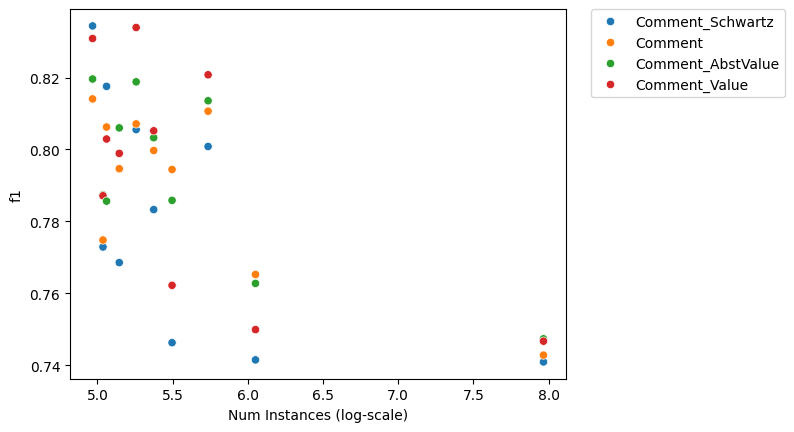

In [133]:
viz_llm_f1('Num Instances (log-scale)', author_to_numInst_log)

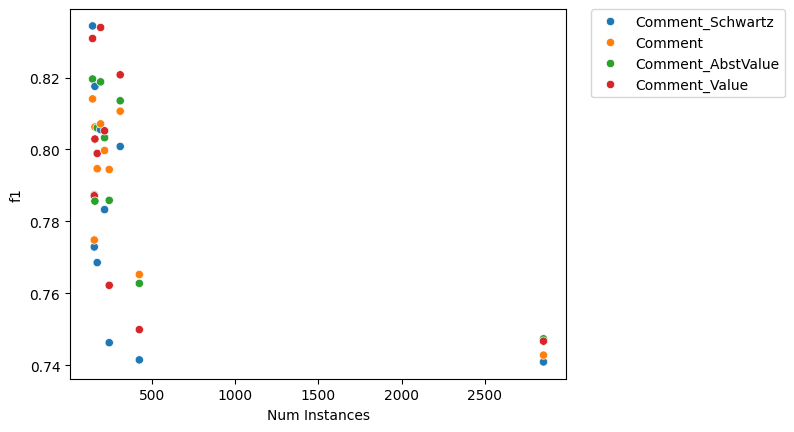

In [134]:
viz_llm_f1('Num Instances', author_to_numInst)

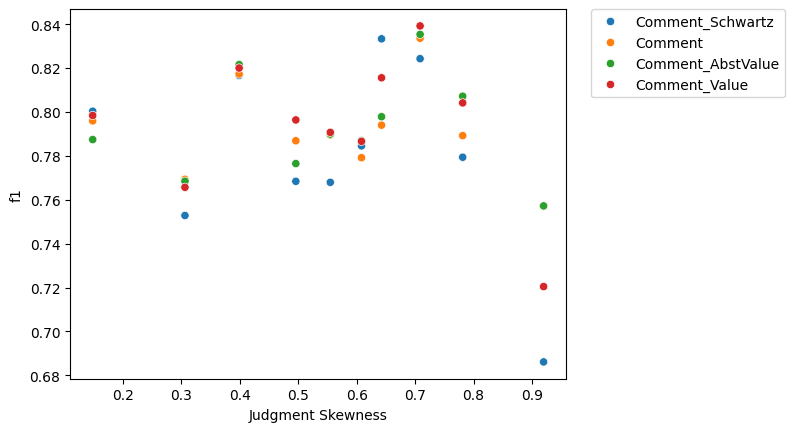

In [135]:
viz_llm_f1('Judgment Skewness', author_to_judgmentPatterns)

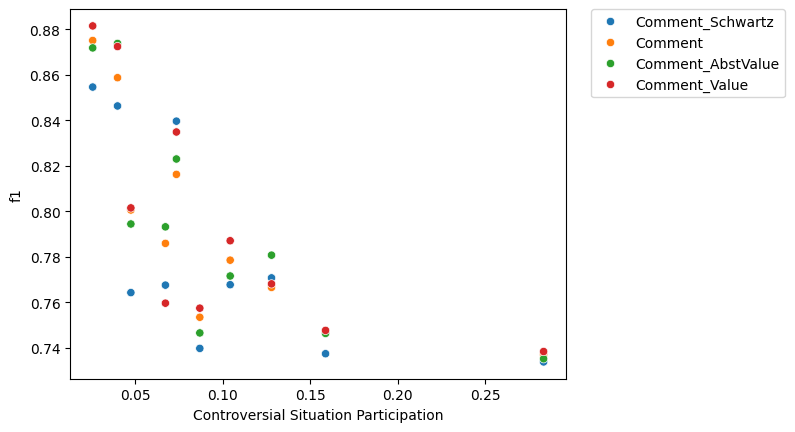

In [136]:
viz_llm_f1('Controversial Situation Participation', author_to_controversialRatio)

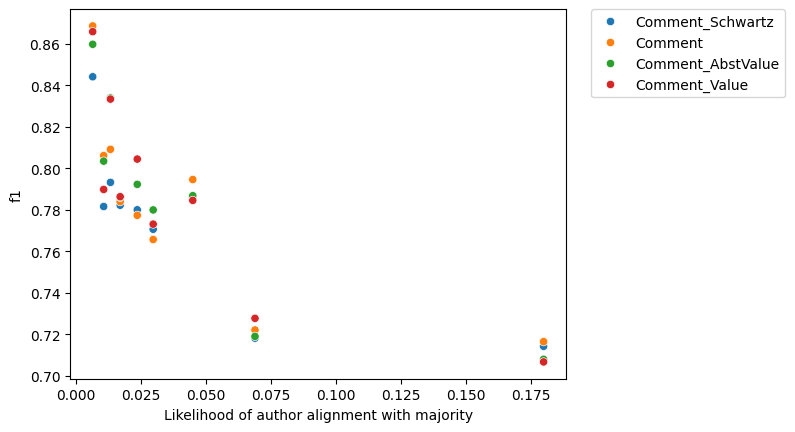

In [137]:
viz_llm_f1('Likelihood of author alignment with majority', author_to_majorityRatio)

In [24]:
from sklearn.preprocessing import QuantileTransformer

def flatten_attr_dict(attr_dict, n_quantiles=10):
    _authors, _list = [], []
    for _author in attr_dict:
        _authors.append(_author)
        _list.append(attr_dict[_author])
    quantile_transformer = QuantileTransformer(output_distribution='uniform', n_quantiles=n_quantiles)
    data = np.array(_list).reshape(-1, 1)
    transformed_data = [elem[0] for elem in quantile_transformer.fit_transform(data)]
    return_dict = {}
    for _author, _mapped_data in zip(_authors, transformed_data):
        return_dict[_author] = _mapped_data
    return return_dict

In [25]:
author_to_numInst_flat = flatten_attr_dict(author_to_numInst)
author_to_majorityRatio_flat = flatten_attr_dict(author_to_majorityRatio)
author_to_controversialRatio_flat = flatten_attr_dict(author_to_controversialRatio)
author_to_judgmentPatterns_flat = flatten_attr_dict(author_to_judgmentPatterns)
author_to_numInst_judgmentPatterns_flat = flatten_attr_dict(author_to_numInst_judgmentPatterns)

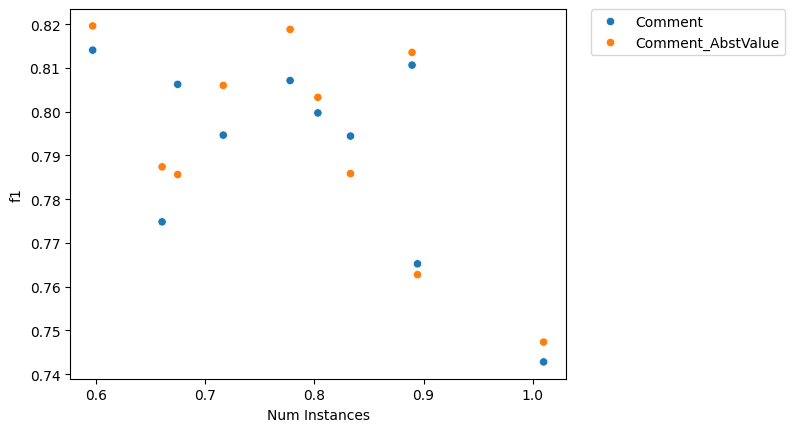

In [179]:
viz_llm_f1('Num Instances', author_to_numInst_flat, pass_list=[ "AbstValue", "Comment_Schwartz", "Comment_Value"])

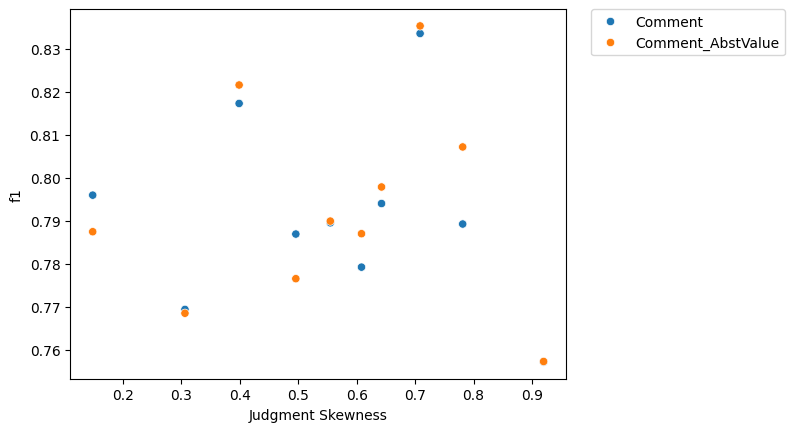

In [183]:
viz_llm_f1('Judgment Skewness', author_to_judgmentPatterns, pass_list=[ "AbstValue", "Comment_Schwartz", "Comment_Value"])

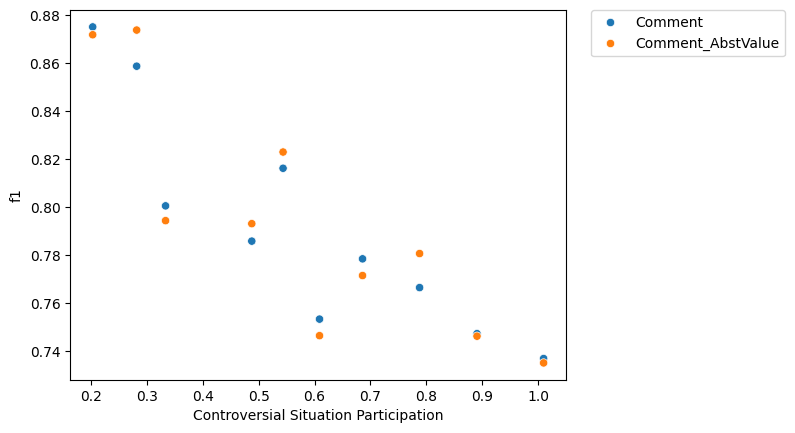

In [181]:
viz_llm_f1('Controversial Situation Participation', author_to_controversialRatio_flat, pass_list=[ "AbstValue", "Comment_Schwartz", "Comment_Value"])

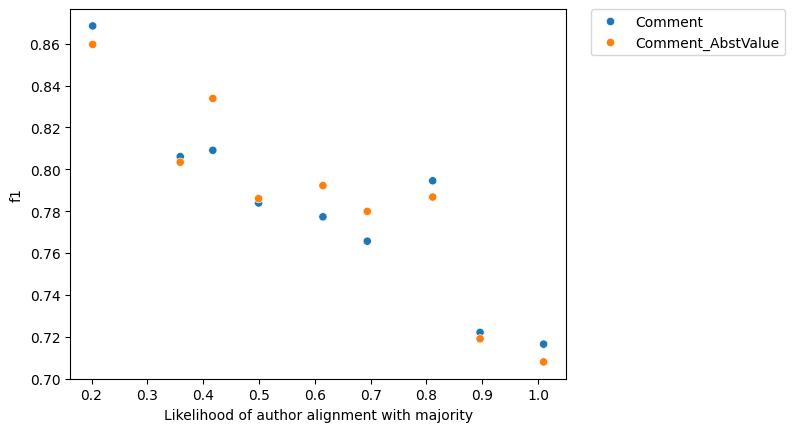

In [182]:
viz_llm_f1('Likelihood of author alignment with majority', author_to_majorityRatio_flat, pass_list=[ "AbstValue", "Comment_Schwartz", "Comment_Value"])

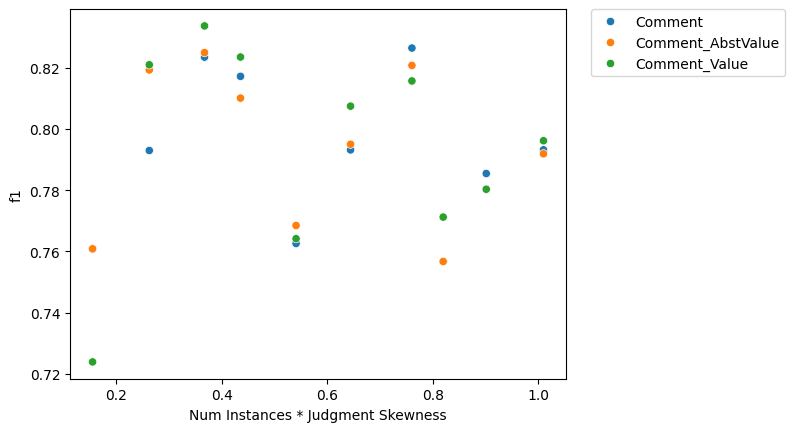

In [221]:
viz_llm_f1('Num Instances * Judgment Skewness', author_to_numInst_judgmentPatterns_flat, pass_list=[ "AbstValue", "Comment_Schwartz", ])

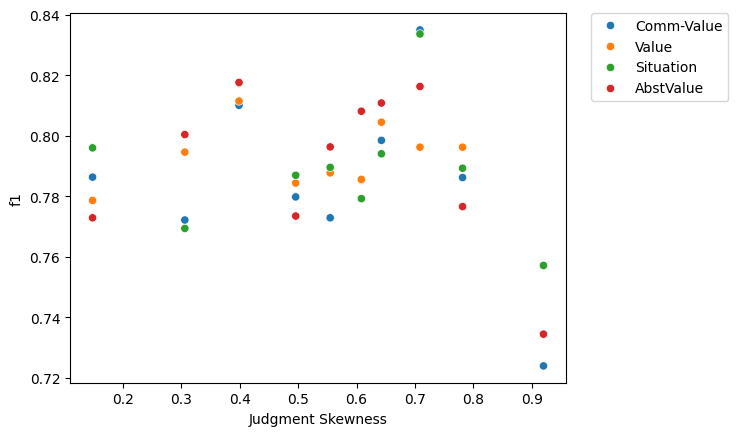

In [188]:
viz_llm_f1('Judgment Skewness', author_to_judgmentPatterns, fix='input', pass_list=['Schwartz',])

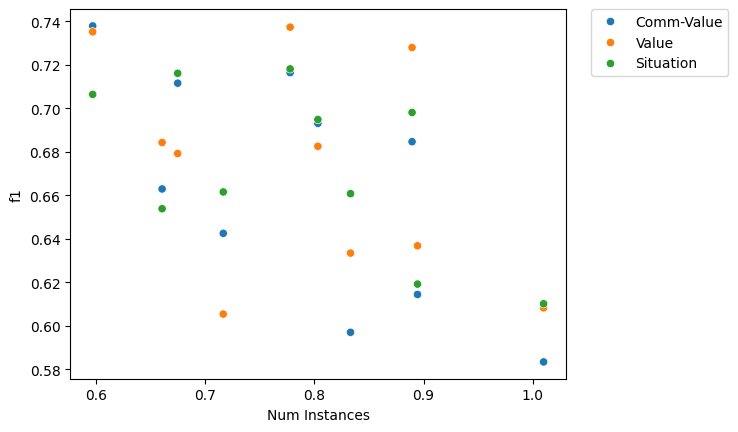

In [200]:
viz_llm_f1('Num Instances', author_to_numInst_flat, fix='input', pass_list=['Schwartz','AbstValue',], mode='minority')

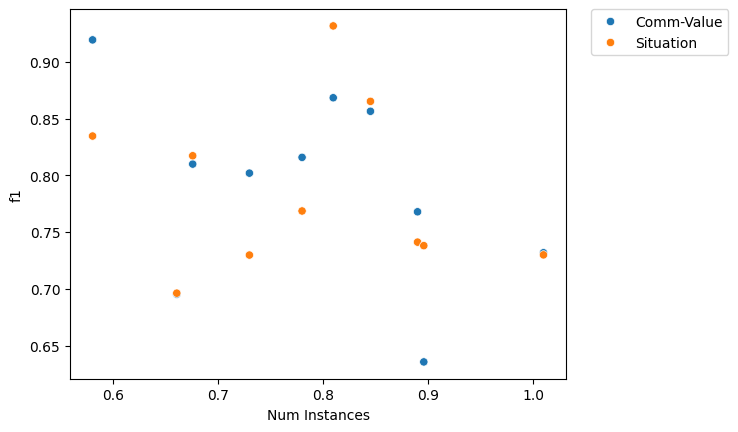

In [216]:
viz_llm_f1('Num Instances', author_to_numInst_flat, fix='input', pass_list=['Schwartz','AbstValue','Value'], isHard=True, )

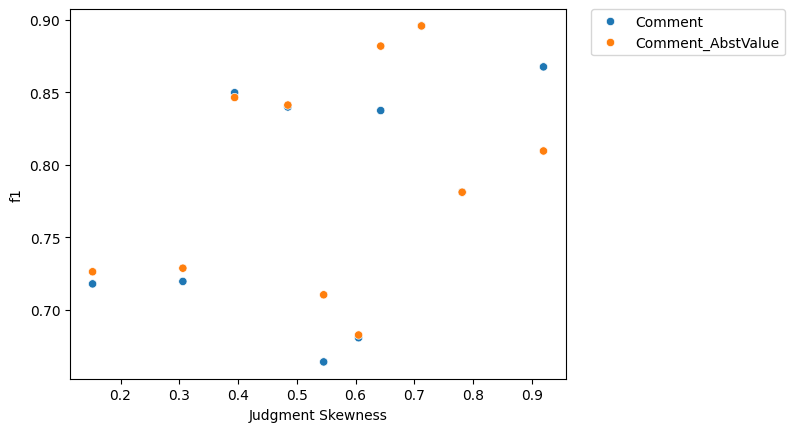

In [217]:
viz_llm_f1('Judgment Skewness', author_to_judgmentPatterns, pass_list=[ "AbstValue", "Comment_Schwartz", "Comment_Value"], isHard=True)
# viz_llm_f1('Num Instances', author_to_numInst_flat, fix='input', pass_list=['Schwartz','AbstValue','Value'], isHard=True, )

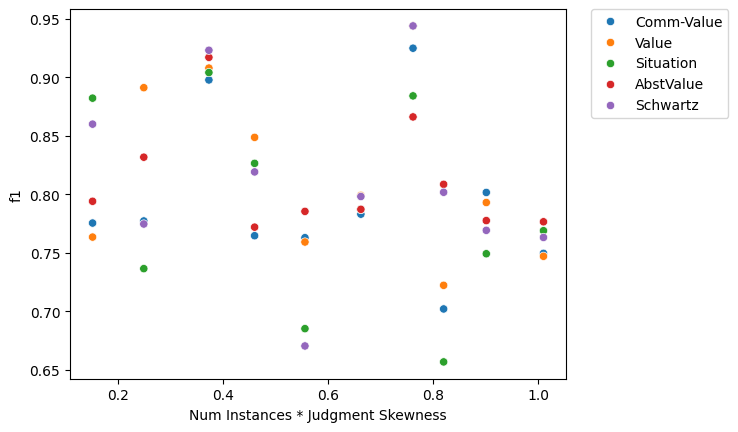

In [222]:
viz_llm_f1('Num Instances * Judgment Skewness', author_to_numInst_judgmentPatterns_flat, fix='input', isHard=True, )

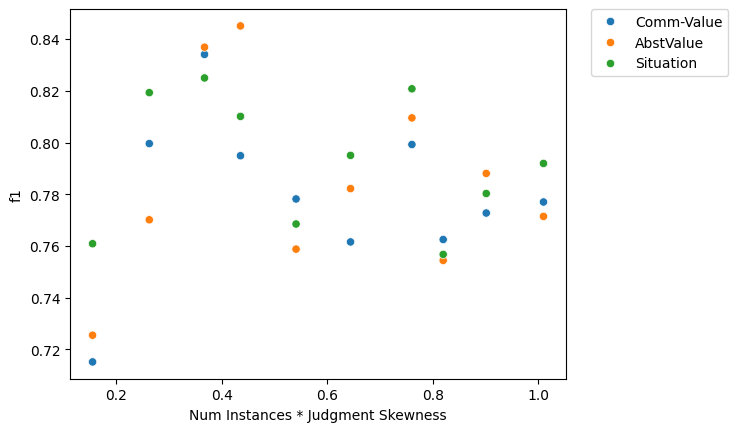

In [29]:
viz_llm_f1('Num Instances * Judgment Skewness', author_to_numInst_judgmentPatterns_flat, fix='input', pass_list=['Random'], input='Comment_AbstValue')

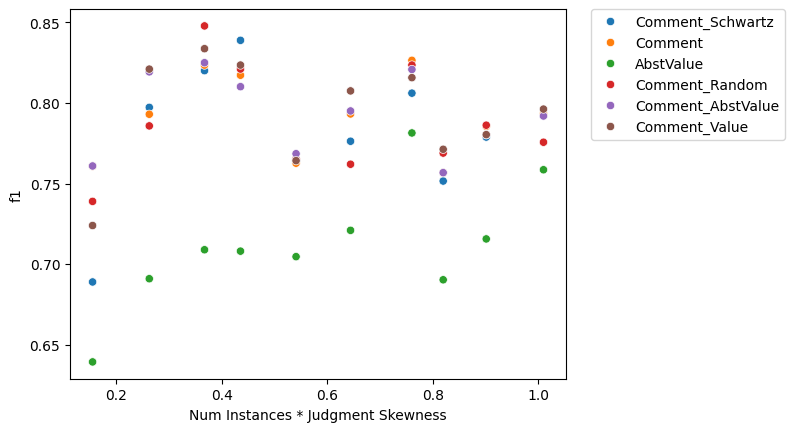

In [224]:
viz_llm_f1('Num Instances * Judgment Skewness', author_to_numInst_judgmentPatterns_flat )

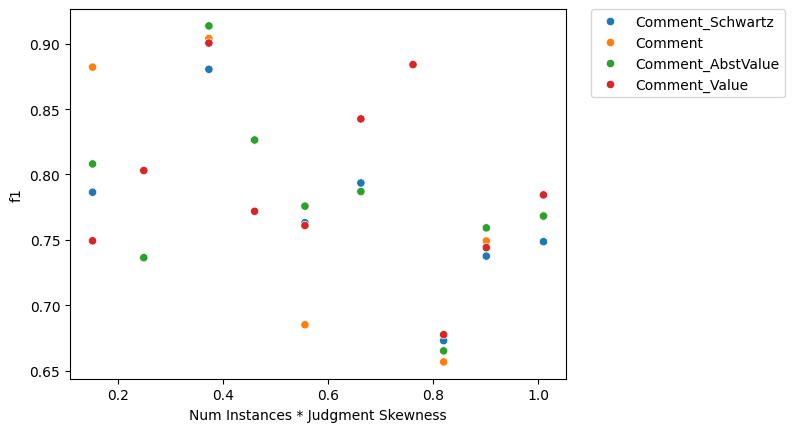

In [26]:
viz_llm_f1('Num Instances * Judgment Skewness', author_to_numInst_judgmentPatterns_flat, isHard=True, pass_list=['AbstValue'])

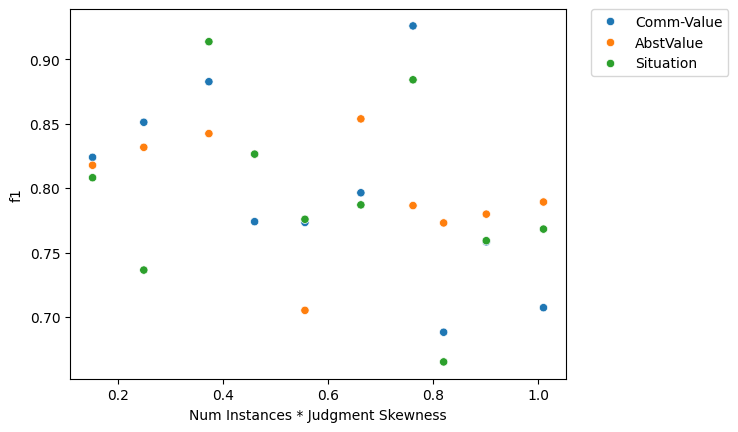

In [30]:
viz_llm_f1('Num Instances * Judgment Skewness', author_to_numInst_judgmentPatterns_flat, fix='input', pass_list=['Random'], input='Comment_AbstValue', isHard=True)

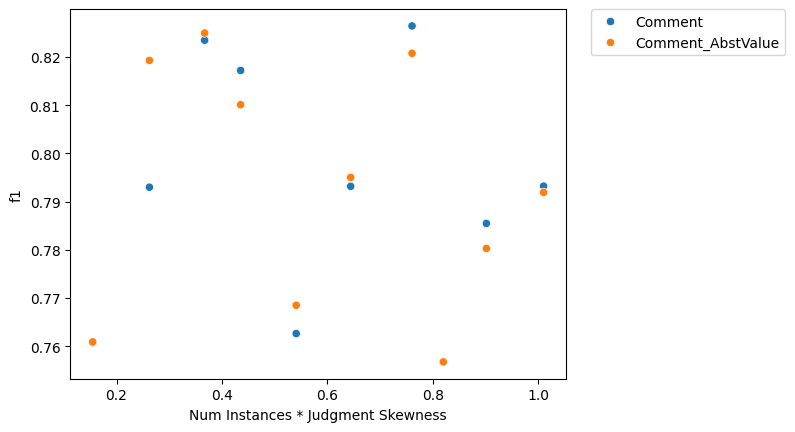

In [32]:
viz_llm_f1('Num Instances * Judgment Skewness', author_to_numInst_judgmentPatterns_flat, pass_list=['AbstValue', 'Comment_Schwartz', 'Comment_Value'])

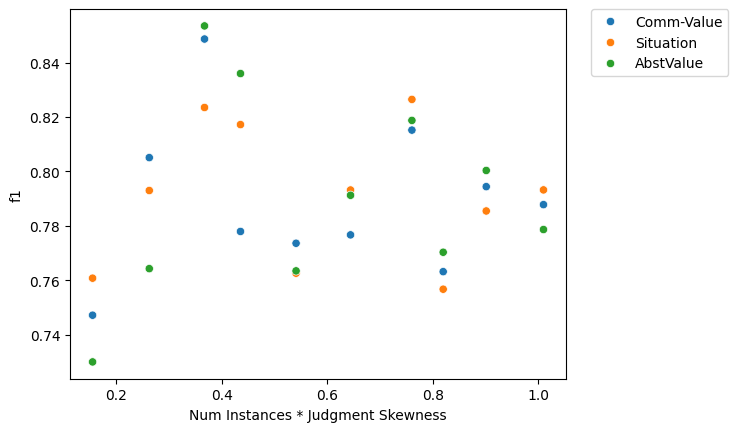

In [34]:
viz_llm_f1('Num Instances * Judgment Skewness', author_to_numInst_judgmentPatterns_flat, fix='input', pass_list=['Random', 'Value', 'Schwartz', 'RandomAuthor'])

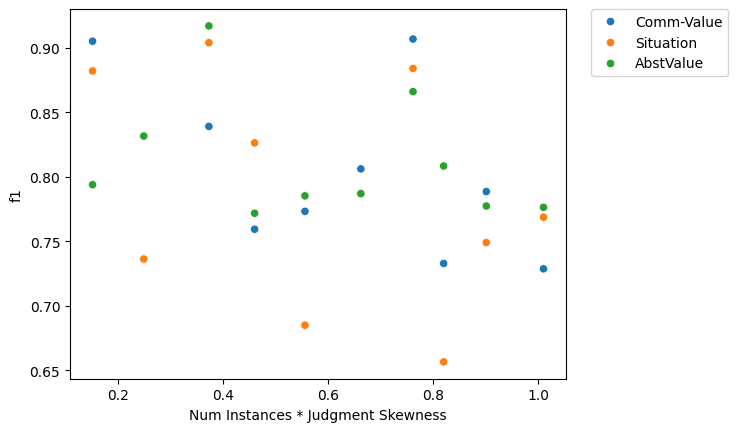

In [35]:
viz_llm_f1('Num Instances * Judgment Skewness', author_to_numInst_judgmentPatterns_flat, fix='input', pass_list=['Random', 'Value', 'Schwartz', 'RandomAuthor'], isHard=True)

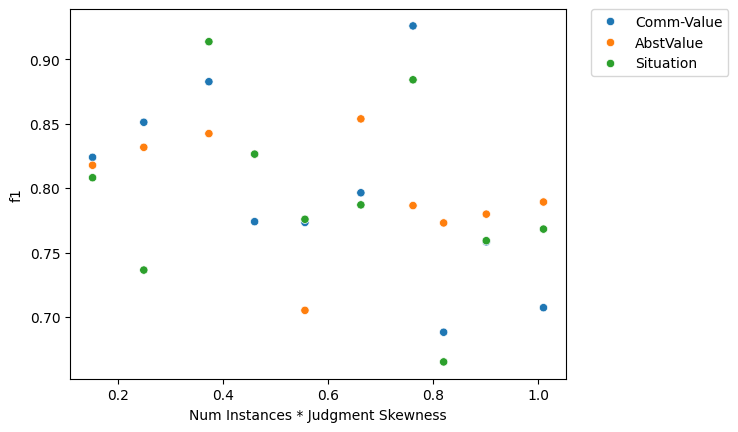

In [37]:
viz_llm_f1('Num Instances * Judgment Skewness', author_to_numInst_judgmentPatterns_flat, fix='input', pass_list=['Random', 'Value', 'Schwartz', 'RandomAuthor'], input='Comment_AbstValue', isHard=True)

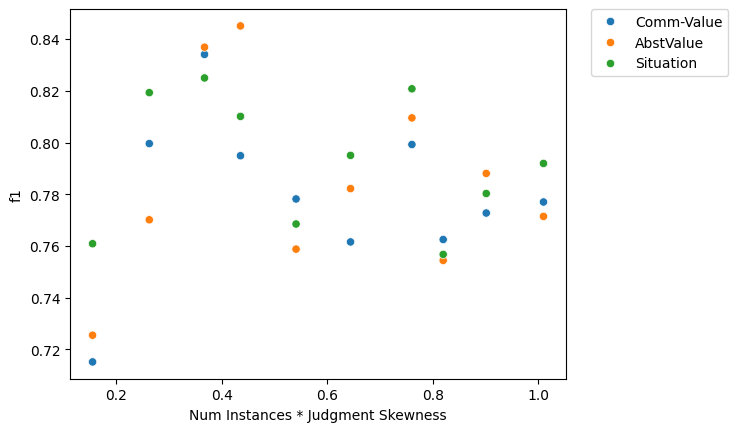

In [38]:
viz_llm_f1('Num Instances * Judgment Skewness', author_to_numInst_judgmentPatterns_flat, fix='input', pass_list=['Random', 'Value', 'Schwartz', 'RandomAuthor'], input='Comment_AbstValue')

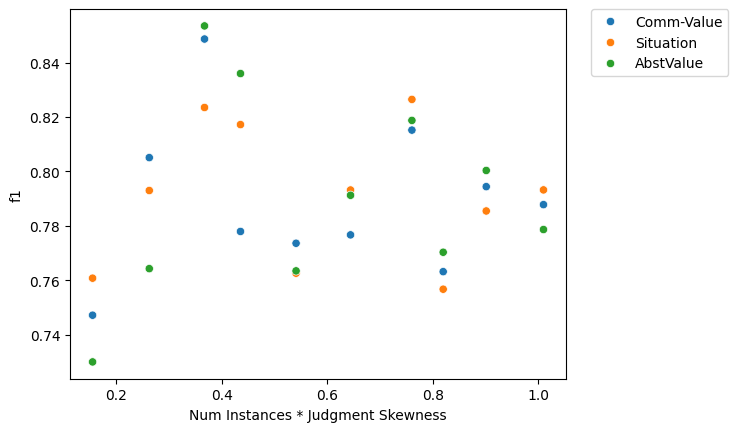

In [39]:
viz_llm_f1('Num Instances * Judgment Skewness', author_to_numInst_judgmentPatterns_flat, fix='input', pass_list=['Random', 'Value', 'Schwartz', 'RandomAuthor'], input='Comment')